# Analyzing Taxi Time Series Data with Matrix Profiles

This example utilizes the main takeways from the research papers: [Matrix Profile I](http://www.cs.ucr.edu/~eamonn/PID4481997_extend_Matrix%20Profile_I.pdf) & [Matrix Profile II](http://www.cs.ucr.edu/~eamonn/STOMP_GPU_final_submission_camera_ready.pdf).

We will be looking at data from taxi passengers in NYC and will be seeing if we can find any patterns or similar subsequences within the time series that we can utilize to determine patterns and outliers.

### Getting Started

Let's import the packages that we'll need to load, analyze, and plot the data.

In [1]:
import pandas as pd
import matrix_profile as mp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import datetime as dt

# Loading Some Data

First, we'll download historical data that represents the half-hourly average of the number of NYC taxi passengers over 75 days in the Fall of 2014.


We extract that data and insert it into a pandas dataframe, making sure the timestamps are stored as *datetime* objects and the values are of type *float64*.

In [2]:
df = pd.read_table("https://raw.githubusercontent.com/stanford-futuredata/ASAP/master/Taxi.csv", sep=',')
df['value'] = df['value'].astype(np.float64)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.head()

,timestamp,value
0,2014-10-01 00:00:00,12751.0
1,2014-10-01 00:30:00,8767.0
2,2014-10-01 01:00:00,7005.0
3,2014-10-01 01:30:00,5257.0
4,2014-10-01 02:00:00,4189.0


The python functions below are going to be used throughout this example to automatically resize and create the plots that are displayed using the Matplotlib python plotting package.

In [3]:
def change_plot_size(width, height, plt):
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = width
    fig_size[1] = height
    plt.rcParams["figure.figsize"] = fig_size
    
def create_plot(plot_title, x_axis_title, y_axis_title, data, plt):
    plt.suptitle(plot_title[0], fontsize = plot_title[1])
    plt.xlabel(x_axis_title[0], fontsize = x_axis_title[1])
    plt.ylabel(y_axis_title[0], fontsize = y_axis_title[1])
    plt.plot(data)
    

# This code is used to control the font used in the plots
plt.rcParams['font.sans-serif'] = "Trebuchet MS"
plt.rcParams['font.family'] = "sans-serif"

plt.rcParams['xtick.direction'] = 'out'

# This code is going to be utilized to control the axis labeling cof the plots
DAY_MULTIPLIER = 7  # Specify for the amount of days you want between each labeled x-axis tick

x_axis_labels = df[(df.timestamp.dt.hour==0)]['timestamp'].dt.strftime('%b %d').values[::DAY_MULTIPLIER]
x_axis_labels[1::2] = " "

x_axis_labels, DAY_MULTIPLIER

(array(['Oct 01', ' ', 'Oct 08', ' ', 'Oct 15', ' ', 'Oct 22', ' ',
        'Oct 29', ' ', 'Nov 05', ' ', 'Nov 12', ' ', 'Nov 19', ' ',
        'Nov 26', ' ', 'Dec 03', ' ', 'Dec 10', ' '], dtype=object), 7)

Now we are going to plot the raw time series, and see if there are any patterns or outliers we can see by just looking at the plotted time series.

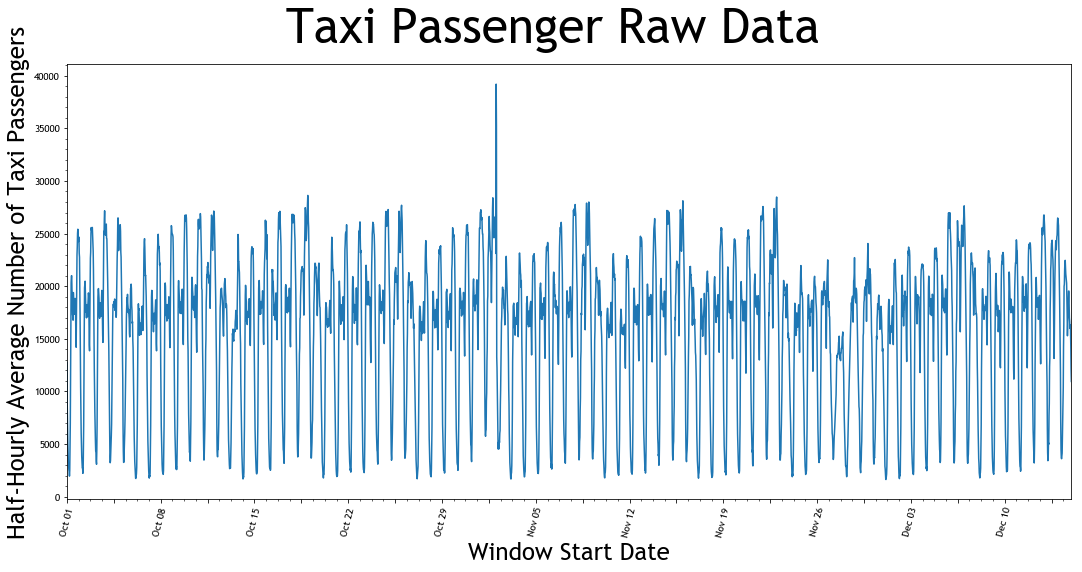

In [4]:
change_plot_size(18,8, plt)
create_plot(('Taxi Passenger Raw Data','48'),
            ('Window Start Date','24'), 
            ('Half-Hourly Average Number of Taxi Passengers','24'),
            df['value'].values, plt)

plt.xticks(np.arange(0,len(df['value'].values),(48*DAY_MULTIPLIER)/2),x_axis_labels)
plt.xticks(rotation=75)
plt.minorticks_on()
plt.margins(x=0)
plt.show()

It seems as if there is a general periodicity between spans of 1-day and 7-days, which can likely be explained by the fact that more people use taxis throughout the day than through the night and that it is reasonable to say most weeks have similar taxi-rider patterns. Also, maybe there is an outlier just to the right of the window starting near the end of October, but other than that there isn't anything you can conclude from just looking at the raw data.

# Generating the Matrix Profile

The Matrix Profile is a new data mining tool that searches for exact subsequence matches. In plain language, it allows you to quickly identify the closest match to any pattern in the time series AND it allows you to quickly identify outliers as well! Isn't that awesome?

Now we are going to generate a matrix profile and then utilize our package's code to generate a matrix profile and then plot it to see if we can extract any patterns from the data.

First, you will need to declare a window size,`m`, to use as the subsequence length (i.e., a sequence of values from our time series that is a subset of the entire time series). Defining the subsequence length usually requires some level of domain knowledge that allow you to determine an adequate window size. Since this data was taken half-hourly, we chose a value `m = 48` to represent the span of exactly one day.

**Note that in this notebook, we will use *m*, *Window Size*, and *Subsequence Length* interchangeably**

In [5]:
m = 48

Now if only we had an algorithm that we could use to locate patterns and outliers within the time series. Oh wait...we do! it's called *STOMP*

*STOMP* performs an ordered search for patterns and outliers within a specified time series, and takes advantage of the locality of some calculations to minimize the runtime.

We now have everything we need to run our dataset through the STOMP Algorithm, let's do just that and plot the results.

In [6]:
stomp_results = mp.stomp.stomp(df['value'].values, df['value'].values, m=m)
out_df = pd.DataFrame(stomp_results, columns=['mp', 'inx', 'left', 'right'])
out_df.head()

Arrays T_A, T_B are equal, which implies a self-join.
Try setting `ignore_trivial = True`.

A large number of values are smaller than 1e-05.
For a self-join, try setting `ignore_trivial = True`.


,mp,inx,left,right
0,5.26414e-07,0,-1,0
1,5.05762e-07,1,0,1681
2,5.65459e-07,2,1,1682
3,5.84004e-07,3,2,1683
4,5.65459e-07,4,3,1684


For clarity, we store the output inside a pandas dataframe

The dataframe output contains an index along with four columns of data and 
this is how each can be interpreted:

The leftmost column represents the index of the time series where the window begins that we are looking at

**mp**: This is the matrix profile value and represents the euclidian distance between the specified index's window and it's closest correspinding subsequence

**inx**: This represents the index of the closest matching window, so the euclidian distance between the dataframe indexed window and the **inx** window is the value located in the same row under the **mp** column

You can interpret the first row of the dataframe as, "The window starting at index 0 of time series T_A has a closest matching window starting at index 0 of series T_B, with a euclidian distance of  5.26414e-07 between them"

For now, you can ignore the **left** & **right** columns. If you are curious, they are explained throughout [Matrix Profile VII](http://www.cs.ucr.edu/~eamonn/chains_ICDM.pdf)


# Plotting the Matrix Profile

We are going to need to extract just the Matrix Profile values if we are looking to plot it, which has been done below

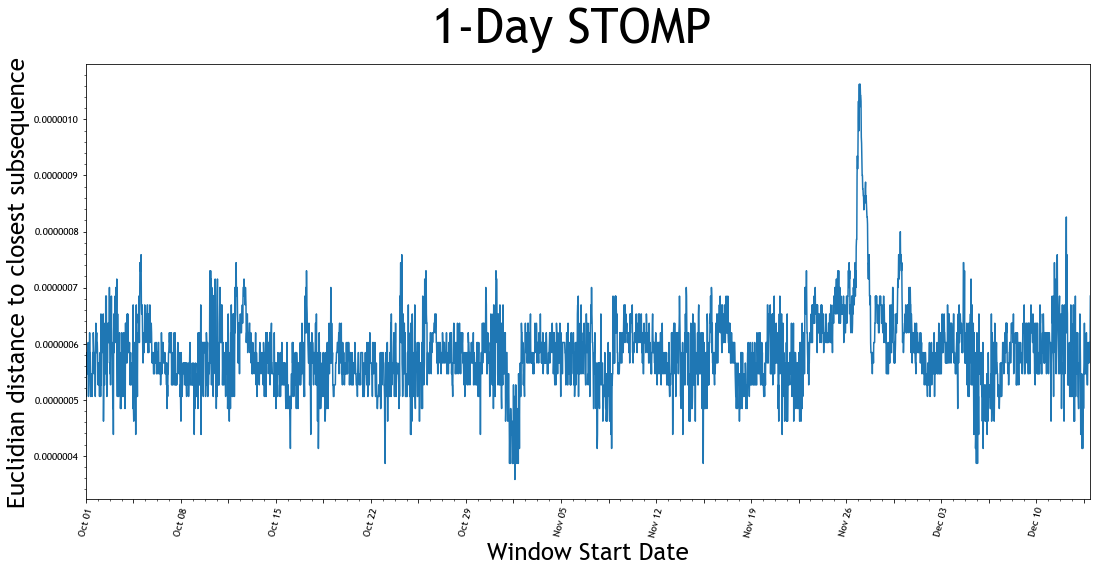

In [7]:
MP = [item[0] for item in stomp_results]  # Extracting only the Matrix Profile values from the STOMP-returned 


create_plot(('1-Day STOMP','48'),
            ('Window Start Date','24'), 
            ('Euclidian distance to closest subsequence','24'),
            MP, plt)

plt.minorticks_on()
plt.margins(x=0)
plt.xticks(np.arange(0,len(MP),(m*DAY_MULTIPLIER)/2),x_axis_labels)
plt.xticks(rotation=75)
plt.show()

### Uh-oh This Looks Questionable!

We seem to be getting a very small range of values along the y-axis, that are all approximately zero. This is because we forgot to set the `ignore_trivial` flag to `True` for the STOMP function. Without having done that, our function is going to ignore the *exclusion zone* (see figure 2 of [Matrix Profile I](http://www.cs.ucr.edu/~eamonn/PID4481997_extend_Matrix%20Profile_I.pdf) ). Now let's try running it with the `ignore_trivial` flag set to `True`, and plot that.

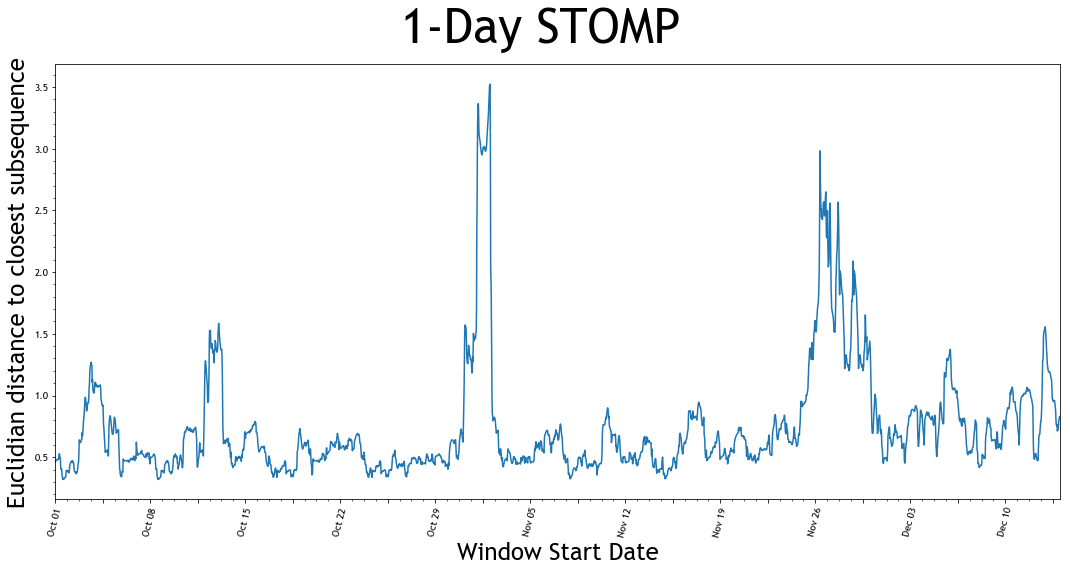

In [8]:
stomp_results = mp.stomp.stomp(df['value'].values, df['value'].values, m=m, ignore_trivial=True)
MP = [item[0] for item in stomp_results]  # Extracting only the MP values from the STOMP-returned 

create_plot(('1-Day STOMP','48'),
            ('Window Start Date','24'), 
            ('Euclidian distance to closest subsequence','24'),
            MP, plt)

plt.minorticks_on()
plt.margins(x=0)
plt.xticks(np.arange(0,len(MP),(m*DAY_MULTIPLIER)/2),x_axis_labels)
plt.xticks(rotation=75)
plt.show()

# Matrix Profile Analysis through STOMP

Now this is what we were looking for! Now there's a good range of values between zero and 4. Let's get into the analysis.

### Lowest Values

The lowest values in this graph are considered the *best motifs* , as they represent that corresponding subsequence window (specified by the x-axis) has a closest subsequence with the distance *j* (specified by the y-axis). In this example, we can see that the 2 lowest values are located at `x=27` and `x=363`, those points in the graph have been highlighted with open triangles below.

It happens to be that the 2 lowest data points are *exactly* 7 days apart, suggesting that in this dataset, there might be a periodicity of seven days, in addition to the more obvious periodicity of one day (*Taxi Example, Part III*).

### Highest Values

So what about the highest values? The indices that have the highest values on the graph represent the uniqueness of their corresponding subsequence. Meaning that there is not an existing subsequence that is relatively close to the specified subsequence (in terms of euclidian distance). We found that the top 3 peaks in the graph happened to correspond exactly with the timing of Columbus Day, Daylight Saving Time, and Thanksgiving, respectively. The specified peaks are highlighted by downward-pointing triangles in the graph below.

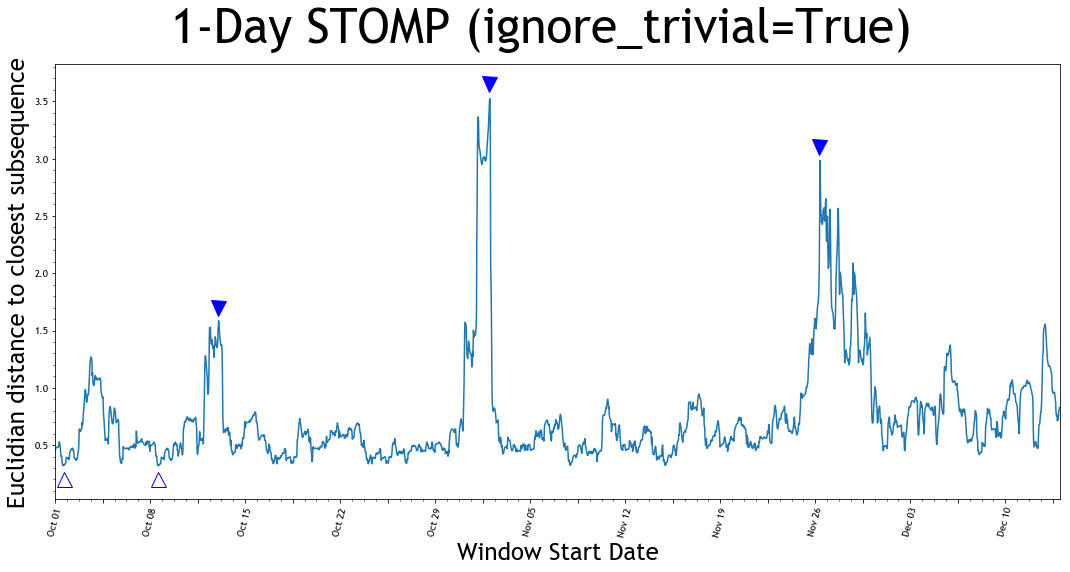

In [9]:
create_plot(('1-Day STOMP (ignore_trivial=True)','48'),
            ('Window Start Date','24'), 
            ('Euclidian distance to closest subsequence','24'),
            MP, plt)

plt.plot(575,1.7, marker="v", markersize=15, color='b')
plt.plot(1535,3.65, marker="v", markersize=15, color='b')
plt.plot(2700,3.1, marker="v", markersize=15, color='b')
plt.plot(30,.2, marker="^", markersize=15, color='b', fillstyle='none')
plt.plot(363,.2, marker="^", markersize=15, color='b', fillstyle='none') 
plt.xticks(np.arange(0,3553,(m*DAY_MULTIPLIER)/2),x_axis_labels)
plt.xticks(rotation=75)
plt.minorticks_on()
plt.margins(x=0)
plt.show()

# Different Window Sizes

Manipulating the window size can have little impact on your resulting Matrix Profile. For example, the code below runs STOMP with windows of the corresponding lengths in the dictionary.

In [10]:
days_dict ={
  "Half-Day": 24,
  "1-Day": 48,
  "2-Days": 96,
  "5-Days": 240,
  "7-Days": 336,
}

dataframe = pd.DataFrame.from_dict(days_dict, orient='index', columns=['m'])

dataframe.head()

,m
Half-Day,24
1-Day,48
2-Days,96
5-Days,240
7-Days,336


We purposely chose spans of corresponding day-lengths that we thought would be reasonable to digest.

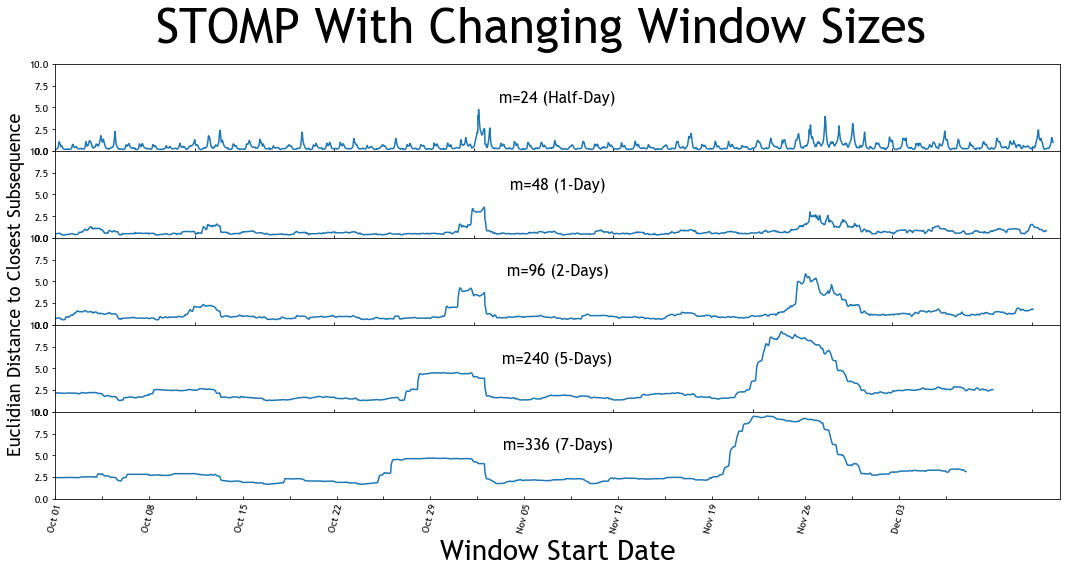

In [11]:
# Adjusting sizing for output
change_plot_size(18,8, plt)

plt.figure(1)
plt.suptitle('STOMP With Changing Window Sizes', fontsize='48')
index=1  # Keeps track of in-order index of dictionary (need for call to plt.subplot)

for k,i in days_dict.items():
    
    plt.rcParams['xtick.direction'] = 'in'
    figure = plt.subplot(len(days_dict), 1, index)
    temp = mp.stomp.stomp(df['value'].values, df['value'].values, days_dict[k], ignore_trivial=True)
    MP = [item[0] for item in temp]  # Extracting only the MP values from the STOMP-returned
    figure.set_title('m='+ str(days_dict[k]) + ' (' + k + ')', fontsize=16, y=.5)
    plt.ylim(0,10)
    plt.xlim(0,3600)
    if k == list(days_dict.keys())[-1]: # Last key in dictionary
        plt.xticks(np.arange(0,len(MP),(m*DAY_MULTIPLIER)/2),x_axis_labels)
        plt.xticks(rotation=75)
        plt.ylabel('Euclidian Distance to Closest Subsequence',horizontalalignment='left', fontsize='18')
        plt.xlabel('Window Start Date', fontsize='28')
    else:
        figure.set_xticklabels([])
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0)
    plt.plot(MP)
    index = index + 1

plt.show()

We can see that even with varying subsequence lengths, our peaks stay prominent. But it looks as if all the non-peak values are converging towards each other. This is why having a knowledge of the data-context is important prior to running to the STOMP algorithm, as it is helpful to have a window size that may that may caputre a repeating pattern, or outlier, within the dataset.

# Summary

And that's it! You have now loaded in a dataset, ran it through the STOMP algorithm using our package, and were able to extract multiple conclusions of existing patterns and outliers within the time series. You can now import this package and use it in your own projects. Happy coding!

# Resources

[Matrix Profile I](http://www.cs.ucr.edu/~eamonn/PID4481997_extend_Matrix%20Profile_I.pdf)

[Matrix Profile II](http://www.cs.ucr.edu/~eamonn/STOMP_GPU_final_submission_camera_ready.pdf)